In [1]:
import pickle
from itertools import permutations

import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Define path to folder with Kaggle files.
PATH_TO_DATASET = "./download"

# Kaggle

Before you participate in the Kaggle competitions, it is great to be informed about its [ranking system](https://www.kaggle.com/progression). This system is pretty straightforward as it is intended to track the growth of the users on this platform. On your journey to the top, you will learn a lot, earn medals, make new friends and form teams. As you progress you will compete in live challenges and engage in discussion boards for real-world problems. There are certain competitions and company projects restricted for “Kaggle Masters” only; you need to unlock that level to witness another world of data science and machine learning work and glory.

Let’s start by looking at the categories that are based on your expertise and interests.

The progression system on Kaggle is specifically designed to cater for different levels of expertise. There are four main **categories** – *Competitions*, *Notebooks*, *Datasets*, and *Discussion* with their own rules of progression and rewards. Advancing from one performance tier to another is all up to you. You need to ascertain the level of expertise and the kind of data that you can handle with confidence as you move along.

## Users

In [3]:
# Load users information.
users = pd.read_csv(f"{PATH_TO_DATASET}/Users.csv")
users.head()

,Id,UserName,DisplayName,RegisterDate,PerformanceTier
0,1,kaggleteam,Kaggle Team,03/24/2011,5
1,368,antgoldbloom,Anthony Goldbloom,01/20/2010,5
2,381,iguyon,Isabelle,01/29/2010,2
3,383,davidstephan,David Stephan,02/01/2010,0
4,384,gabewarren,Gabe Warren,02/02/2010,0


In [4]:
len(users)

7173429

In [5]:
users["Id"].is_unique

True

In [6]:
users["UserName"].is_unique

True

In [7]:
users["DisplayName"].is_unique

False

In [8]:
users.isna().sum()

Id                   0
UserName             1
DisplayName        281
RegisterDate         0
PerformanceTier      0
dtype: int64

### Keys description

- **Id**: the id of the user (UserId);
- **UserName**: the username of the user (for the login);
- **DisplayName**: the display name is the name visible to other members on the forum. It can be different from the username which is used at login. More users can have the same *DisplayName*;
- **RegisterDate**: the date of the user's registration;
- **PerformanceTier**: there are five performance tiers that can be achieved in accordance with the quality and quantity of work you produce: Novice (0), Contributor (1), Expert (2), Master (3), and Grandmaster (4) ((5) if the user belongs to Kaggle staff). It is possible to rank differently in each category such as a Discussions Master, a Notebooks Novice, and a Competitions Contributor. The highest tier that you achieve in any category is what will be reflected on your Kaggle profile just under your avatar/picture. So how are tiers awarded to a contributor? Pretty simple it depends on the number of medals that a contributor earns in that category. The *PerformanceTier* of this dataset reflect the maximum tier among the categories that the users have (or if Kaggle staff).

<div align="center">
<img src="profile.png" width="500">
</div>

In [9]:
users["PerformanceTier"].unique()

array([5, 2, 0, 1, 3, 4], dtype=int64)

In [10]:
# Convert datetime column to appropriate type.
users["RegisterDate"] = pd.to_datetime(users["RegisterDate"])
# Not consider 'UserName' column.
users.drop("UserName", axis = 1, inplace = True)

In [11]:
# Rename Id column.
users.rename({"Id": "UserId"}, axis = 1, inplace = True)

#### Preprocessing

In [12]:
# The 'UserName' or 'DisplayName' equal to NaN could be users that kept 'NaN' name.
# In order to avoid confusion, we don't consider these users.
users.dropna(inplace = True)

In [13]:
# Create dictionary {node_id: "name"}.
id_to_name_nodes = users[["UserId", "DisplayName"]].set_index("UserId")["DisplayName"].to_dict()

## Teams

In [14]:
# Load teams information.
teams = pd.read_csv(f"{PATH_TO_DATASET}/Teams.csv", low_memory = False)
teams.head()

,Id,CompetitionId,TeamLeaderId,TeamName,ScoreFirstSubmittedDate,LastSubmissionDate,PublicLeaderboardSubmissionId,PrivateLeaderboardSubmissionId,IsBenchmark,Medal,MedalAwardDate,PublicLeaderboardRank,PrivateLeaderboardRank
0,496,2435,647.0,team1,05/04/2010,05/04/2010,2192.0,2192.0,False,NaN,09/06/2018,59.0,83.0
1,497,2435,619.0,jonp,04/30/2010,04/30/2010,2182.0,2182.0,False,3.0,07/15/2016,41.0,25.0
2,499,2435,663.0,Bwaas,05/01/2010,05/01/2010,2184.0,2184.0,False,NaN,09/06/2018,102.0,100.0
3,500,2435,673.0,Thylacoleo,05/02/2010,07/10/2010,2187.0,2187.0,False,3.0,07/15/2016,31.0,23.0
4,501,2435,435.0,pjonesdotcda,05/04/2010,05/05/2010,2194.0,2191.0,False,NaN,09/06/2018,67.0,80.0


In [15]:
len(teams)

4215293

In [16]:
teams["Id"].is_unique

True

In [17]:
teams.isna().sum()

Id                                      0
CompetitionId                           0
TeamLeaderId                        22789
TeamName                              513
ScoreFirstSubmittedDate           3980503
LastSubmissionDate                3694524
PublicLeaderboardSubmissionId     3705374
PrivateLeaderboardSubmissionId    3705374
IsBenchmark                             0
Medal                             4173428
MedalAwardDate                    4153163
PublicLeaderboardRank             3708162
PrivateLeaderboardRank            3708162
dtype: int64

In [18]:
# Number of unique competitions.
teams["CompetitionId"].nunique()

4227

### Keys description

- **Id**: the id of the team (TeamId);
- **CompetitionId**: the id of the Kaggle Competitions; the competitions are designed to provide challenges for competitors at all different stages of their machine learning careers. As a result, they are very diverse, with a range of broad types;
- **TeamLeaderId**: the user leader Id of the team;
- **TeamName**: the name of the team (display name);
- **ScoreFirstSubmittedDate**: the date when the team submitted its first score for the the current competition;
- **LastSubmissionDate**: the date when the team submitted its last score for the the current competition;
- **PublicLeaderboardSubmissionId**: the id of the submission that it is used to get corresponding results into public leaderbord;
- **PrivateLeaderboardSubmissionId**: the id of the submission that it is used to get corresponding results into private leaderbord;
- **IsBenchmark**: 
- **Medal**: to earn a medal in the competition category, you need to get top competition results. How many medals a user is awarded depends on the size of a particular competition. Keep in mind that Getting Started competitions, Playground Competitions, and In-class Competitions do not earn any medals. You only earn medals in the competitions category through featured competitions. If a competition has up to 250 contestants, you need to rank in the top 40% to get a bronze ('3' label), top 20% to get a silver ('2' label) and top 10% for a gold ('1' label) medal. For competition with 250 to 500 contestants, you need to rank in the top hundred to get a bronze, top fifty for a silver model and top ten in addition to be in 0.2% for a gold medal. In a competition with more than 1,000 teams, you need to rank in the top 10% to get a bronze medal, top 5% for a silver model and top 10 in the leader-board (in addition to 0.2%) for a gold medal. The teams that not get any medal the label is 'nan'.
- **MedalAwardDate**: the date when team earned the medal in the current competition;
- **PublicLeaderboardRank**: for all participants, the same 50% of predictions from the test set are assigned to the public leaderboard. The score you see on the public leaderboard reflects your model’s accuracy on this portion of the test set. So, it is the rank computed using your performance on this set of data. In this case, the rank is meant as the position in the leaderbord, e.g. if the *PublicLeaderboardRank* of a team is 5, it's means that the team is the fifth in the leaderbord of the current competition.
- **PrivateLeaderboardRank**: the other 50% (it depends by the competition) of predictions from the test set are assigned to the private leaderboard. The private leaderboard is not visible to participants until the competition has concluded. At the end of a competition, we will reveal the private leaderboard so you can see your score on the other 50% of the test data. The scores on the private leaderboard are used to determine the competition winners. So, it is the rank computed using your performance on this set of data.

In [19]:
# Rename Id columns
teams.rename({"Id": "TeamId"}, axis = 1, inplace = True)

In [20]:
# Keep only some columns.
teams = teams[["TeamId", "CompetitionId", "TeamLeaderId", "TeamName", "Medal", "MedalAwardDate", "PrivateLeaderboardRank"]]

In [21]:
# Convert datetime column to appropriate type.
teams["MedalAwardDate"] = pd.to_datetime(teams["MedalAwardDate"])

In [22]:
teams["Medal"].unique()

array([nan,  3.,  1.,  2.,  0.])

#### Preprocessing

In [23]:
# Check number of rows that have Medal 0 (what does it means 0 medal?).
len(teams[teams["Medal"] == 0])

24

In [24]:
# Not consider rows where Medal is 0 for semplicity.
teams = teams[~(teams["Medal"] == 0)]

In [25]:
# Create dictionary {team_id: "name"}.
id_to_name_teams = teams[["TeamId", "TeamName"]].set_index("TeamId")["TeamName"].to_dict()

In [26]:
# Save a copy with which compute medals for competitions.
teams_copy = teams.copy()

N.B. The *TeamId* is different among the competitions: a team could have the same members into different competitions but it will have always a different *TeamId*.

## Competitions

In [27]:
# Load competitions information.
competitions = pd.read_csv(f"{PATH_TO_DATASET}/Competitions.csv")
competitions.head()

,Id,Slug,Title,Subtitle,HostSegmentTitle,ForumId,OrganizationId,CompetitionTypeId,HostName,EnabledDate,...,EnableSubmissionModelHashes,EnableSubmissionModelAttachments,RewardType,RewardQuantity,NumPrizes,UserRankMultiplier,CanQualifyTiers,TotalTeams,TotalCompetitors,TotalSubmissions
0,13979,testing-a-competition-with-no-data,Testing a competition with no data,"Who needs data, not I",InClass,168327.0,NaN,1,NaN,04/05/2019 20:14:39,...,False,False,NaN,NaN,1,0.0,False,0,0,0
1,14595,ntut-dl-app-hw3,VizDoom Competition,Training an AI warrior!,InClass,205047.0,NaN,1,NaN,05/15/2019 14:10:27,...,False,False,NaN,NaN,1,0.0,False,57,57,117
2,16647,test-for-an-inclass-comp,Test for an inclass comp.,It is a test for inclass competition.,InClass,426342.0,NaN,1,NaN,11/13/2019 08:21:17,...,False,False,NaN,NaN,1,0.0,False,0,0,0
3,17859,108-1-dl-app-hw3,VizDoom Competition,NTUT Building Deep Learning Applications Homew...,InClass,451149.0,NaN,1,NaN,12/08/2019 05:57:10,...,False,False,NaN,NaN,1,0.0,False,84,84,170
4,2408,Eurovision2010,Forecast Eurovision Voting,This competition requires contestants to forec...,Featured,2.0,NaN,1,NaN,04/07/2010 07:57:43,...,False,False,USD,1000.0,1,1.0,False,22,25,22


In [28]:
len(competitions)

4220

In [29]:
competitions.columns

Index(['Id', 'Slug', 'Title', 'Subtitle', 'HostSegmentTitle', 'ForumId',
       'OrganizationId', 'CompetitionTypeId', 'HostName', 'EnabledDate',
       'DeadlineDate', 'ProhibitNewEntrantsDeadlineDate',
       'TeamMergerDeadlineDate', 'TeamModelDeadlineDate',
       'ModelSubmissionDeadlineDate', 'FinalLeaderboardHasBeenVerified',
       'HasKernels', 'OnlyAllowKernelSubmissions', 'HasLeaderboard',
       'LeaderboardPercentage', 'LeaderboardDisplayFormat',
       'EvaluationAlgorithmAbbreviation', 'EvaluationAlgorithmName',
       'EvaluationAlgorithmDescription', 'EvaluationAlgorithmIsMax',
       'ValidationSetName', 'ValidationSetValue', 'MaxDailySubmissions',
       'NumScoredSubmissions', 'MaxTeamSize', 'BanTeamMergers',
       'EnableTeamModels', 'EnableSubmissionModelHashes',
       'EnableSubmissionModelAttachments', 'RewardType', 'RewardQuantity',
       'NumPrizes', 'UserRankMultiplier', 'CanQualifyTiers', 'TotalTeams',
       'TotalCompetitors', 'TotalSubmissions'],
     

In [30]:
competitions["Id"].is_unique

True

### Keys description

- **Id**: the id of the competition;
- **Slug**: an abbreviation for the competition name;
- **Title**: the title of the competition;
- **TotalCompetitors**: the total number of teams that join on the current competition;
- **TotalCompetitors**: the total members of the teams that join on the current competition;
- **TotalSubmissions**: the total number of submissions (each team can upload a script/kernel (solution) multiple times (there exist some constraints)) among all the partecipants (teams).

In [31]:
# Rename Id column.
competitions.rename({"Id": "CompetitionId"}, axis = 1, inplace = True)

In [32]:
# Keep only some columns.
competitions = competitions[["CompetitionId", "Title", "HostSegmentTitle", "EnabledDate", "DeadlineDate", 
                             "TotalCompetitors", "TotalTeams"]]

In [33]:
# Convert datetime column to appropriate type.
competitions["EnabledDate"] = pd.to_datetime(competitions["EnabledDate"])
competitions["DeadlineDate"] = pd.to_datetime(competitions["DeadlineDate"])

In [34]:
competitions.isna().sum()

CompetitionId       0
Title               0
HostSegmentTitle    0
EnabledDate         0
DeadlineDate        0
TotalCompetitors    0
TotalTeams          0
dtype: int64

In [35]:
# Get type of competitions.
competitions.groupby("HostSegmentTitle")["CompetitionId"].nunique()

HostSegmentTitle
Featured            196
GE Quests             5
Getting Started       6
InClass            3789
Playground           77
Prospect              7
Recruitment          17
Research            123
Name: CompetitionId, dtype: int64

In [36]:
competitions_copy = competitions.copy()

## TeamMemberships

In [37]:
# Load team memberships information.
teamMembers = pd.read_csv(f"{PATH_TO_DATASET}/TeamMemberships.csv")
teamMembers.head()

,Id,TeamId,UserId,RequestDate
0,16458,518,635,NaN
1,16464,526,839,NaN
2,16465,527,816,NaN
3,16466,528,778,NaN
4,16467,529,747,NaN


In [38]:
len(teamMembers)

4310234

In [39]:
teamMembers["Id"].is_unique

True

In [40]:
teamMembers["TeamId"].is_unique

False

In [41]:
teamMembers.isna().sum()

Id                0
TeamId            0
UserId            0
RequestDate    7615
dtype: int64

### Keys description

- **Id**: an unique row identifier;
- **TeamId**: the id of the team;
- **UserId**: the id of the user;
- **RequestDate**:

In [42]:
# Delete 'Id' column.
teamMembers.drop("Id", axis = 1, inplace = True)
# Not consider rows where we don't know the 'RequestDate'.
teamMembers.dropna(inplace = True)

In [43]:
# Convert datetime column to appropriate type.
teamMembers["RequestDate"] = pd.to_datetime(teamMembers["RequestDate"])

In [44]:
teamMembers.head()

,TeamId,UserId,RequestDate
25,469024,200660,2017-02-06
26,494689,777876,2017-02-20
27,512626,937118,2017-03-01
28,515650,933895,2017-03-03
29,520368,915112,2017-03-06


In [45]:
teamMembers_copy = teamMembers.copy()

## Followers

In [46]:
# Load followers information.
followers = pd.read_csv(f"{PATH_TO_DATASET}/UserFollowers.csv")
followers.head()

,Id,UserId,FollowingUserId,CreationDate
0,64,368,993,05/23/2017
1,122289,368,67483,08/07/2018
2,323230,368,1663522,09/18/2019
3,412502,368,1302389,03/08/2020
4,447841,368,391404,04/27/2020


In [47]:
len(followers)

697766

In [48]:
followers.isna().sum()

Id                 0
UserId             0
FollowingUserId    0
CreationDate       0
dtype: int64

### Keys description

- **Id**: an unique row identifier;
- **UserId**: the id of the user;
- **FollowingUserId**: the user id that the current user follows;
- **CreationDate**: date creation of the connection;

In [49]:
# Delete 'Id' column.
followers.drop("Id", axis = 1, inplace = True)

In [50]:
# Convert datetime column to appropriate type.
followers["CreationDate"] = pd.to_datetime(followers["CreationDate"])
# Rename columns connections: ID1 -> ID2.
followers.rename({"UserId": "ID1", "FollowingUserId": "ID2"}, axis = 1, inplace = True)

In [51]:
followers.head()

,ID1,ID2,CreationDate
0,368,993,2017-05-23
1,368,67483,2018-08-07
2,368,1663522,2019-09-18
3,368,1302389,2020-03-08
4,368,391404,2020-04-27


# Kaggle preprocessing

At first, we search the teams that partecipate at some competitions during a selected period. These teams will be considered *active* and we will create a label for each team. Each team partecipates to only a single competition: as said before, a team could have the same members into different competitions but it will have always a different TeamId. We fix this situation considering the teams with same partecipants to be the same team.

In [52]:
# Define the period into which we want to keep the competitions.
START_DATE = "2020-11-01"
END_DATE = "2021-06-01"

In [53]:
# Keep only teams that have a value into the 'PrivateLeaderboardRank'.
teams = teams[teams["PrivateLeaderboardRank"].notnull()]

In [54]:
# Normalization private ranking position based on competition.
def norm(x):
    return 1 - MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).ravel()

teams["PrivateLeaderboardRankNormalized"] = teams.groupby("CompetitionId")["PrivateLeaderboardRank"].transform(norm)

In [55]:
# Keep only teams with all members into 'users' table (probably deleted users if not appear).
teams_with_some_deleted_members = teamMembers[~(teamMembers["UserId"].isin(users["UserId"]))]["TeamId"].unique()
teams = teams[~(teams["TeamId"].isin(teams_with_some_deleted_members))]

In [56]:
# Keep only some types of competitions (the competitions where the medals can be earned by teams).
#competitions = competitions[competitions["HostSegmentTitle"].isin(["Featured", "Research"])]
# Keep competitions between the selected period.
competitions = competitions[(competitions["EnabledDate"] >= pd.to_datetime(START_DATE)) &
                            (competitions["DeadlineDate"] < pd.to_datetime(END_DATE))]
# Keep competitions with a number of competitors greater than 1000.
#competitions = competitions[(competitions["TotalCompetitors"] >= 1000)]

In [57]:
# Get teams that partecipate into the selected competitions.
teams = teams[teams["CompetitionId"].isin(competitions["CompetitionId"])]
teamMembers = teamMembers[teamMembers["TeamId"].isin(teams["TeamId"])]

In [58]:
# Compute team size (all the teams).
team_size = teamMembers.groupby("TeamId")["UserId"].nunique()
team_size.value_counts()

UserId
1    51618
2     2466
3     1139
4      681
5      377
7       15
6        6
8        2
Name: count, dtype: int64

In [59]:
# Consider only teams with size > 3.
s = team_size > 3
teams_greater = s[s].index

teamMembers = teamMembers[teamMembers["TeamId"].isin(teams_greater)]
teams = teams[teams["TeamId"].isin(teams_greater)]

In [60]:
# Get team composition and size.
teamMembers = teamMembers.groupby("TeamId", as_index = False).agg(Members = ("UserId", lambda x: x.unique().tolist()))
teamMembers["Size"] = teamMembers["Members"].apply(len)
teamMembers.head()

,TeamId,Members,Size
0,5770480,"[373959, 2560033, 3198184, 4206802, 3885917]",5
1,5783778,"[5906670, 5906569, 2547846, 5906677, 6125650]",5
2,5784465,"[6108296, 5906554, 6108138, 6108278, 5959360]",5
3,5788349,"[6113078, 937522, 6108981, 6113198]",4
4,5788464,"[6113269, 6113145, 6113263, 301832, 6113308]",5


In [61]:
# Group teams that have same components but resulting into different TeamId.
teamMembers["Members_encoded"] = teamMembers["Members"].apply(lambda x: str(sorted(x)))
teamMembers["Group"] = teamMembers.groupby("Members_encoded").ngroup()

In [62]:
# Print the number of teams that partecipate to multiple competitions resulting into different TeamId.
teamMembers.groupby("Group")["TeamId"].count().value_counts()

TeamId
1    966
2     37
3      5
4      2
5      1
6      1
7      1
Name: count, dtype: int64

In [63]:
# Keep one single team for those ones that have different TeamId (the first one groupping them).
teamMembers["unique_TeamId"] = teamMembers.groupby("Group")["TeamId"].transform("first")

In [64]:
# Create mapping to have unique teams.
mapping_multiple_teams = teamMembers[["TeamId", "unique_TeamId"]].set_index("TeamId")["unique_TeamId"].to_dict()

In [65]:
# Keep unique teams.
teams["unique_TeamId"] = teams["TeamId"].map(mapping_multiple_teams)
teams = teams.groupby("unique_TeamId", as_index = False).agg(PrivateLeaderboardRankNormalized = ("PrivateLeaderboardRankNormalized", "mean"))
teamMembers = teamMembers[teamMembers["TeamId"].isin(teamMembers["unique_TeamId"].unique())]

In [66]:
teamMembers = teamMembers[["TeamId", "Members", "Size"]]
teams.rename({"unique_TeamId": "TeamId"}, axis = 1, inplace = True)

In [67]:
# Number of teams.
selected_teams = teamMembers["TeamId"].unique()
len(selected_teams)

1013

In [68]:
# Number of members.
selected_users = teamMembers["Members"].explode().unique()
len(selected_users)

4183

### Connections

We decide to keep the connections until the end of the reference date.

In [69]:
# Keep connections created before reference date.
followers = followers[followers["CreationDate"] < pd.to_datetime(END_DATE)]

In [70]:
# Check the connections that exist using the followers table.
followers_selected = followers[followers["ID1"].isin(selected_users) & followers["ID2"].isin(selected_users)]
followers_selected.reset_index(drop = True, inplace = True)

In [71]:
len(followers_selected)

4063

In [72]:
# Check the number of edges inside the same team.
edges_into_team = teamMembers.explode("Members").groupby("TeamId").apply(lambda x: len(followers_selected[followers_selected["ID1"].isin(x["Members"]) & followers_selected["ID2"].isin(x["Members"])]))

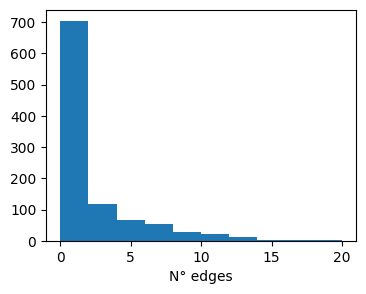

In [73]:
# Plot the histogram representing the connection inside the same team.
fig, ax = plt.subplots(figsize = (4, 3))
ax.hist(edges_into_team)
ax.set_xlabel("N° edges");

## Label

In [74]:
# Target making.
teams["target_encode"] = pd.qcut(teams["PrivateLeaderboardRankNormalized"], 3, labels = False)

In [75]:
privateLeaderboard_ranked = teams[["TeamId", "PrivateLeaderboardRankNormalized"]].sort_values(by = "PrivateLeaderboardRankNormalized").set_index("TeamId")["PrivateLeaderboardRankNormalized"].to_dict()

In [76]:
teams["target_encode"].value_counts() / len(teams)

target_encode
2    0.333662
0    0.333662
1    0.332675
Name: count, dtype: float64

In [77]:
# Get label of the teams.
teams_label = teams.set_index("TeamId")["target_encode"].to_dict()

## Node attributes 

The attributes of the nodes are computed looking at the period before the reference `START_DATE`. It is not possible to keep the attributes of the nodes before the creation of the corresponding competition because many teams may have joined to more than one competition and therefore it would not be possible to obtain an univocal information.

In [78]:
# Select all the teams where the selected users worked, works or will work.
teams_of_selected_users = teamMembers_copy[teamMembers_copy["UserId"].isin(selected_users)]
teams_of_selected_users = pd.merge(teams_of_selected_users, teams_copy, on = "TeamId", how = "left")
teams_of_selected_users.head()

,TeamId,UserId,RequestDate,CompetitionId,TeamLeaderId,TeamName,Medal,MedalAwardDate,PrivateLeaderboardRank
0,19825,48625,2012-07-05,2496.0,48625.0,mlandry,NaN,2018-09-05,191.0
1,6955,9938,2011-09-22,2551.0,9938.0,Winchester,NaN,2018-09-05,145.0
2,7632,18463,2011-10-11,2551.0,18463.0,msdw,NaN,2018-09-06,264.0
3,242018,471945,2015-11-22,2551.0,471945.0,AhmetErdem,NaN,NaT,NaN
4,624478,1035112,2017-04-21,2551.0,1035112.0,shichao,NaN,NaT,NaN


### Past number of competitions

In [79]:
n_competitions = teams_of_selected_users.copy()
n_competitions["mask"] = n_competitions["RequestDate"] < pd.to_datetime(START_DATE)

In [80]:
# Keep the number of competitions with which the users partecipate before the starting reference date.
n_competitions = n_competitions.groupby(["UserId"]).agg(n_competitions = ("mask", "sum"))
n_competitions.head()

,n_competitions
UserId,
5309,292
8507,50
9938,11
14756,83
18187,9


### Past number of teamleader roles

In [81]:
n_teamleaders = teams_of_selected_users.copy()
n_teamleaders["mask"] = (n_teamleaders["UserId"] == n_teamleaders["TeamLeaderId"]) & (n_teamleaders["RequestDate"] < pd.to_datetime(START_DATE))

In [82]:
# Keep the number of teamleader roles with which the users had before the starting reference date.
n_teamleaders = n_teamleaders.groupby(["UserId"]).agg(n_teamleaders = ("mask", "sum"))
n_teamleaders.head()

,n_teamleaders
UserId,
5309,257
8507,48
9938,9
14756,82
18187,8


### Competition medals

In [83]:
tqdm.pandas()
medals_competition = teams_of_selected_users.groupby(["UserId"]).progress_apply(lambda x: x["Medal"][x["MedalAwardDate"] < pd.to_datetime(START_DATE)])
# Get label corresponding to the medal.
medals_competition = medals_competition.reset_index(level = ["UserId"])
medals_competition["Medal_label"] = medals_competition["Medal"].map({1: "competition_gold", 
                                                                     2: "competition_silver", 
                                                                     3: "competition_bronze"})

  0%|          | 0/4183 [00:00<?, ?it/s]

In [84]:
# Get the number of medals earned before the starting reference date.
medals_competition = pd.pivot_table(medals_competition, values = "Medal", index = ["UserId"], 
                                    columns = ["Medal_label"], aggfunc = "count")
medals_competition.head()

Medal_label,competition_bronze,competition_gold,competition_silver
UserId,,,
5309,21.0,18.0,32.0
8507,2.0,2.0,6.0
14756,14.0,2.0,3.0
18187,NaN,NaN,1.0
18463,37.0,5.0,30.0


### Discussion medals

In [85]:
# Load forum messages information.
forumMessages = pd.read_csv(f"{PATH_TO_DATASET}/ForumMessages.csv")
forumMessages.head()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,MedalAwardDate
0,28,16,368,05/12/2010 04:39:30,NaN,Here are some papers that analyze Eurovision v...,NaN,NaN
1,29,16,368,05/12/2010 04:39:30,NaN,More research... enjoy<br><br>Love thy Neighbo...,NaN,NaN
2,993,133,2691,10/10/2010 02:39:04,NaN,<div>@Nan</div><div><br></div><div>Isn't X_i s...,NaN,NaN
3,996,133,2958,10/10/2010 02:39:04,NaN,"Brad,<br>It is not. Y_i is defined as I (S_{i+...",NaN,NaN
4,1009,133,2958,10/10/2010 02:39:04,NaN,"I am back.<br>Sorry to say that, the same mode...",NaN,NaN


In [86]:
len(forumMessages)

1163664

In [87]:
# Convert datetime column to appropriate type.
forumMessages["MedalAwardDate"] = pd.to_datetime(forumMessages["MedalAwardDate"])
# Keep only some columns.
forumMessages.drop(["Id", "Message", "ReplyToForumMessageId", "PostDate", "ForumTopicId"], axis = 1, inplace = True)
# Rename Id column.
forumMessages.rename({"PostUserId": "UserId"}, axis = 1, inplace = True)

In [88]:
# Let's consider only users that belong to the selected active teams.
forumMessages = forumMessages[forumMessages["UserId"].isin(selected_users)]

In [89]:
tqdm.pandas()
medals_discussion = forumMessages.groupby(["UserId"]).progress_apply(lambda x: x["Medal"][x["MedalAwardDate"] < pd.to_datetime(START_DATE)])
# Get label corresponding to the medal.
medals_discussion = medals_discussion.reset_index(level = ["UserId"])
medals_discussion["Medal_label"] = medals_discussion["Medal"].map({1: "discussion_gold", 
                                                                   2: "discussion_silver", 
                                                                   3: "discussion_bronze"})

  0%|          | 0/1110 [00:00<?, ?it/s]

In [90]:
# Get the number of medals earned before the starting reference date.
medals_discussion = pd.pivot_table(medals_discussion, values = "Medal", index = ["UserId"], 
                                   columns = ["Medal_label"], aggfunc = "count")
medals_discussion.head()

Medal_label,discussion_bronze,discussion_gold,discussion_silver
UserId,,,
5309,734.0,117.0,117.0
8507,179.0,34.0,25.0
14756,161.0,9.0,24.0
18463,12.0,1.0,1.0
37166,797.0,84.0,121.0


### Kernel medals

In [91]:
# Load kernel information.
kernels = pd.read_csv(f"{PATH_TO_DATASET}/Kernels.csv")
kernels.head()

,Id,AuthorUserId,CurrentKernelVersionId,ForkParentKernelVersionId,ForumTopicId,FirstKernelVersionId,CreationDate,EvaluationDate,MadePublicDate,IsProjectLanguageTemplate,CurrentUrlSlug,Medal,MedalAwardDate,TotalViews,TotalComments,TotalVotes
0,1,2505,205.0,NaN,NaN,1.0,03/25/2015 18:25:32,03/23/2018,03/25/2015,False,hello,NaN,NaN,155,0,0
1,2,3716,1748.0,NaN,26670.0,2.0,03/25/2015 18:31:07,04/16/2015,03/25/2015,False,rf-proximity,3.0,07/15/2016,8534,1,13
2,4,3716,41.0,NaN,NaN,9.0,03/25/2015 21:57:36,03/23/2018,03/25/2015,False,r-version,NaN,NaN,91,0,0
3,5,28963,19.0,NaN,NaN,13.0,03/25/2015 22:01:04,03/23/2018,03/25/2015,False,test1,NaN,NaN,101,0,0
4,6,3716,21.0,NaN,NaN,15.0,03/25/2015 22:19:00,03/23/2018,03/25/2015,False,are-icons-missing,NaN,NaN,106,0,0


In [92]:
len(kernels)

529611

In [93]:
# Convert datetime column to appropriate type.
kernels["MedalAwardDate"] = pd.to_datetime(kernels["MedalAwardDate"])
# Keep only some columns.
kernels = kernels[["AuthorUserId", "Medal", "MedalAwardDate"]]
# Rename Id column.
kernels.rename({"AuthorUserId": "UserId"}, axis = 1, inplace = True)

In [94]:
# Let's consider only users that belong to the selected active teams.
kernels = kernels[kernels["UserId"].isin(selected_users)]

In [95]:
tqdm.pandas()
medals_kernel = kernels.groupby(["UserId"]).progress_apply(lambda x: x["Medal"][x["MedalAwardDate"] < pd.to_datetime(START_DATE)])
# Get label corresponding to the medal.
medals_kernel = medals_kernel.reset_index(level = ["UserId"])
medals_kernel["Medal_label"] = medals_kernel["Medal"].map({1: "kernel_gold", 
                                                           2: "kernel_silver", 
                                                           3: "kernel_bronze"})

  0%|          | 0/787 [00:00<?, ?it/s]

In [96]:
# Get the number of medals earned before the starting reference date.
medals_kernel = pd.pivot_table(medals_kernel, values = "Medal", index = ["UserId"], 
                               columns = ["Medal_label"], aggfunc = "count")
medals_kernel.head()

Medal_label,kernel_bronze,kernel_gold,kernel_silver
UserId,,,
5309,14.0,31.0,16.0
8507,1.0,NaN,NaN
14756,7.0,3.0,8.0
18463,4.0,NaN,1.0
37166,7.0,NaN,4.0


### All attributes

In [97]:
# Concatenate medals information.
medals = pd.concat([medals_competition, medals_discussion, medals_kernel], axis = 1)
medals.columns = pd.MultiIndex.from_tuples(list(medals.columns.str.split("_")), names = ["Type", "Medal"])
medals.head()

Type   competition              discussion               kernel             
Medal       bronze  gold silver     bronze   gold silver bronze  gold silver
UserId                                                                      
5309          21.0  18.0   32.0      734.0  117.0  117.0   14.0  31.0   16.0
8507           2.0   2.0    6.0      179.0   34.0   25.0    1.0   NaN    NaN
14756         14.0   2.0    3.0      161.0    9.0   24.0    7.0   3.0    8.0
18187          NaN   NaN    1.0        NaN    NaN    NaN    NaN   NaN    NaN
18463         37.0   5.0   30.0       12.0    1.0    1.0    4.0   NaN    1.0

In [98]:
# Keep only the sum of gold, silver and bronze medals.
medals = medals.groupby(axis = 1, level = "Medal").sum()

In [99]:
# Concatenate all attributes.
nodes_attribute = n_competitions.join([n_teamleaders, medals])
nodes_attribute.fillna(0, inplace = True)
nodes_attribute.head()

,n_competitions,n_teamleaders,bronze,gold,silver
UserId,,,,,
5309,292,257,769.0,166.0,165.0
8507,50,48,182.0,36.0,31.0
9938,11,9,0.0,0.0,0.0
14756,83,82,182.0,14.0,35.0
18187,9,8,0.0,0.0,1.0


In [100]:
# Compute team composition in order to insert team information into node attributes table.
composition = teamMembers.explode("Members")
composition["Members"] = composition["Members"].astype(int)
composition = composition.groupby("Members").apply(lambda x: list(x["TeamId"])).to_dict()

In [101]:
# Add team information.
nodes_attribute = nodes_attribute.join(pd.Series(composition, name = "TeamId"), how = "left").explode("TeamId")
nodes_attribute.set_index("TeamId", append = True, inplace = True)
nodes_attribute.head()

,,n_competitions,n_teamleaders,bronze,gold,silver
UserId,TeamId,,,,,
5309,5859778,292,257,769.0,166.0,165.0
8507,5848107,50,48,182.0,36.0,31.0
9938,6341681,11,9,0.0,0.0,0.0
14756,6108783,83,82,182.0,14.0,35.0
18187,6274960,9,8,0.0,0.0,1.0


## Graph

In [102]:
# The users into same team form a clique (fully connected: both directions).
e1 = []
for team, composition in teamMembers.set_index("TeamId")["Members"].to_dict().items(): 
    for src, dst in permutations(composition, 2):
        e1.append((src, dst))

In [103]:
# Extra connections extra team.
followers_extra = followers[followers["ID1"].isin(selected_users) & followers["ID2"].isin(selected_users)]
e2 = list(followers_extra[["ID1", "ID2"]].apply(tuple, axis = 1).values)

In [104]:
e = e1 + e2 # Some edges could be duplicated

In [105]:
# Create networkx graph.
G = nx.DiGraph()
G.add_nodes_from(selected_users)
G.add_edges_from(e) 

In [106]:
G.number_of_nodes()

4183

In [107]:
G.number_of_edges()

17789

## Relabeling team ids

In [108]:
# Create a new id for the team.
teamMembers["team_recoded"] = range(len(teamMembers))
# Save mapping from old ids to new ids.
mapping_teams = teamMembers.set_index("TeamId")["team_recoded"].to_dict()

In [109]:
# Create dictionary information from new team_id to original name.
teams_name = {v: id_to_name_teams[k] for k,v in mapping_teams.items()}
# Relabel team ids into label dictionary.
teams_label = {v: teams_label[k] for k,v in mapping_teams.items()}
privateLeaderboard_ranked = {v: privateLeaderboard_ranked[k] for k,v in mapping_teams.items()}

In [110]:
nodes_attribute.reset_index(inplace = True)
nodes_attribute["TeamId"] = nodes_attribute["TeamId"].map(mapping_teams)

# Construct the team composition: {node_id: [team_id]}.
team_composition = nodes_attribute.groupby("UserId", as_index = True).agg(teams = ("TeamId", lambda x: x.unique().tolist()))
team_composition = team_composition["teams"].to_dict()
nodes_attribute.set_index(["UserId", "TeamId"], inplace = True)
nodes_attribute.head()

,,n_competitions,n_teamleaders,bronze,gold,silver
UserId,TeamId,,,,,
5309,51,292,257,769.0,166.0,165.0
8507,38,50,48,182.0,36.0,31.0
9938,654,11,9,0.0,0.0,0.0
14756,251,83,82,182.0,14.0,35.0
18187,585,9,8,0.0,0.0,1.0


In [111]:
nx.set_node_attributes(G, team_composition, "Team") 

## Relabeling node ids

In [112]:
# Relabel nodes.
G = nx.convert_node_labels_to_integers(G, first_label = 0, label_attribute = "old_ids")

In [113]:
mapping_nodes = nx.get_node_attributes(G, "old_ids")

In [114]:
def inverse_mapping(f):
    return f.__class__(map(reversed, f.items()))

In [115]:
# Mapping the node id into new ones.
nodes_attribute.reset_index(inplace = True)
nodes_attribute["UserId"] = nodes_attribute["UserId"].map(inverse_mapping(mapping_nodes))
nodes_attribute.set_index(["UserId", "TeamId"], inplace = True)
nodes_attribute.sort_index(inplace = True)
nodes_attribute.index.names = ["node", "team"]

In [116]:
# Get dictionary from new node id to original node name.
nodes_name = {v: id_to_name_nodes[k] for k, v in inverse_mapping(mapping_nodes).items()}

## Output data

In [117]:
# Save Networkx graph.
with open("./data/graph.pkl", "wb") as f:
    pickle.dump(nx.readwrite.json_graph.node_link_data(G), f)

# Save teams label.
with open("./data/teams_label.pkl", "wb") as out:
    pickle.dump(teams_label, out)
    
# Save node attributes.
with open("./data/nodes_attribute.pkl", "wb") as f:
    pickle.dump(nodes_attribute, f)
    
# Save node names.
with open("./data/nodes_name.pkl", "wb") as out:
    pickle.dump(nodes_name, out)
    
# Save node names.
with open("./data/teams_name.pkl", "wb") as out:
    pickle.dump(teams_name, out)
    
# Save teams continuous label.
with open("./data/teams_continuous_label.pkl", "wb") as out:
    pickle.dump(privateLeaderboard_ranked, out)